In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import os

In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 51.5 MB/s eta 0:00:00


In [ ]:
import mediapipe as mp

In [ ]:
mpPose = mp.solutions.pose
pose = mpPose.Pose(static_image_mode=True)
mpDraw = mp.solutions.drawing_utils # For drawing keypoints
points = mpPose.PoseLandmark # Landmarks

In [ ]:
path="/content/drive/MyDrive/YogaData/train"

In [ ]:
folders=["downdog","goddess","plank","tree","warrior2"]

In [ ]:
dd_path=os.path.join(path, folders[0])

In [ ]:
def get_x_coord(mp_pose_output):
  list_landmark=mp_pose_output.pose_landmarks.landmark
  length=33
  x=np.zeros(length)
  for i in range(length):
    x[i]=mp_pose_output.pose_landmarks.landmark[i].x
  return x

In [ ]:
def get_y_coord(mp_pose_output):
  list_landmark=mp_pose_output.pose_landmarks.landmark
  length=33
  y=np.zeros(length)
  for i in range(length):
    y[i]=mp_pose_output.pose_landmarks.landmark[i].y
  return y

In [ ]:
def get_coord(mp_pose_output):
  return np.vstack([get_x_coord(results),get_y_coord(results)]).T

In [ ]:
img_size = 256

training_data = []
training_labels = []

In [ ]:
%%time
training_data=[]
training_labels=[]
hits=0
miss=0
for folder in folders:
    folder_path = os.path.join(path, folder)
    for img_file in os.listdir(folder_path):
      # if hits%100==0:
        # print(f"hits,{hits}")
      img_path = os.path.join(folder_path, img_file)

      img = cv2.imread(img_path)
      img = cv2.resize(img, (img_size, img_size))
      # imageWidth, imageHeight = img.shape[:2]

      imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      results = pose.process(imgRGB)
      if results.pose_landmarks:
        
        hits+=1
        training_data.append(get_coord(results))
        training_labels.append(folders.index(folder))
      else:
        miss+=1
        # images.append(img)

CPU times: user 2min 30s, sys: 2 s, total: 2min 32s
Wall time: 3min 2s


In [ ]:
%%time
print(hits,miss)

0 2
CPU times: user 62 µs, sys: 2 µs, total: 64 µs
Wall time: 69.1 µs


In [ ]:
%%time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
count=0
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    channel_shift_range=0.2)
 
augmented_data = []
augmented_labels = []
 
for folder in folders:
    # print(folder,count)    
    folder_path = os.path.join(path, folder)
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = img / 255.0

        # augmented_data.append(img)
        # augmented_labels.append(folders.index(folder)) 
        img = img.reshape((1,) + img.shape)
        for batch in datagen.flow(img, batch_size=1):
            augmented_img = batch[0]
            results = pose.process(augmented_img.astype("uint8"))
            if results.pose_landmarks:
              training_data.append(get_coord(results))
              training_labels.append(folders.index(folder))
            break



CPU times: user 2min 59s, sys: 2.02 s, total: 3min 1s
Wall time: 3min 13s


In [ ]:
training_data = np.array(training_data)
training_labels = np.array(training_labels)
 
print("Training data shape:", training_data.shape)
print("Training labels shape:", training_labels.shape)

Training data shape: (3404, 33, 2)
Training labels shape: (3404,)


In [ ]:
%%time

hits=0
miss=0
test_path = r"/content/drive/MyDrive/YogaData/test"
test_data = []
test_labels = []
count=0
for folder in folders:
    folder_path = os.path.join(test_path, folder)
    for img_file in os.listdir(folder_path):
      img_path = os.path.join(folder_path, img_file)

      img = cv2.imread(img_path)
      # imageWidth, imageHeight = img.shape[:2]
      img=cv2.resize(img, (img_size, img_size))
      imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      results = pose.process(imgRGB)
      if results.pose_landmarks:
        test_data.append(get_coord(results))
        test_labels.append(folders.index(folder))
        count += 1
      else:
        miss+=1
        # images.append(img)


print(hits,miss)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

0 7
CPU times: user 33.4 s, sys: 412 ms, total: 33.8 s
Wall time: 2min 43s


# TF

In [ ]:
input_shape = (33,2)
 
model = models.Sequential([
    layers.Conv1D(16,3, activation='relu', input_shape=input_shape),# output 31,2
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(len(folders), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
checkpoint_filepath="/tmp/checkpoint"
model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_loss",
    mode='max',
    save_best_only=True
)

In [ ]:
history = model.fit(training_data, training_labels, epochs=50, validation_split=0.2,callbacks=[model_checkpoint_callback])

Epoch 1/50
86/86 [==============================] - 12s 9ms/step - loss: 1.1066 - accuracy: 0.5509 - val_loss: 1.6113 - val_accuracy: 0.0059
Epoch 2/50
86/86 [==============================] - 0s 5ms/step - loss: 0.6738 - accuracy: 0.7422 - val_loss: 1.3913 - val_accuracy: 0.1894
Epoch 3/50
86/86 [==============================] - 0s 5ms/step - loss: 0.5368 - accuracy: 0.8035 - val_loss: 1.1978 - val_accuracy: 0.3583
Epoch 4/50
86/86 [==============================] - 0s 5ms/step - loss: 0.4555 - accuracy: 0.8402 - val_loss: 0.9642 - val_accuracy: 0.4846
Epoch 5/50
86/86 [==============================] - 0s 6ms/step - loss: 0.3882 - accuracy: 0.8733 - val_loss: 0.7369 - val_accuracy: 0.6755
Epoch 6/50
86/86 [==============================] - 0s 5ms/step - loss: 0.3565 - accuracy: 0.8806 - val_loss: 0.6545 - val_accuracy: 0.7122
Epoch 7/50
86/86 [==============================] - 0s 5ms/step - loss: 0.3318 - accuracy: 0.8917 - val_loss: 0.6405 - val_accuracy: 0.7283
Epoch 8/50
86/86 [=

In [ ]:
history.history

{'loss': [1.1065855026245117,
  0.6737663149833679,
  0.5367745757102966,
  0.4555124342441559,
  0.38815683126449585,
  0.35654619336128235,
  0.3318478763103485,
  0.3169741630554199,
  0.2905992865562439,
  0.28241291642189026,
  0.2849296033382416,
  0.28212419152259827,
  0.2685568630695343,
  0.28148749470710754,
  0.25081416964530945,
  0.26377934217453003,
  0.23758858442306519,
  0.23266133666038513,
  0.24406088888645172,
  0.24355235695838928,
  0.23493210971355438,
  0.24039775133132935,
  0.2397642433643341,
  0.2309061735868454,
  0.24729381501674652,
  0.23309911787509918,
  0.2232017070055008,
  0.23286254703998566,
  0.21737869083881378,
  0.22729021310806274,
  0.23086977005004883,
  0.21483711898326874,
  0.22219276428222656,
  0.20400367677211761,
  0.20817828178405762,
  0.1989702582359314,
  0.2040913701057434,
  0.22203370928764343,
  0.21037231385707855,
  0.2091497778892517,
  0.20310711860656738,
  0.2100694626569748,
  0.19481633603572845,
  0.200350373983383

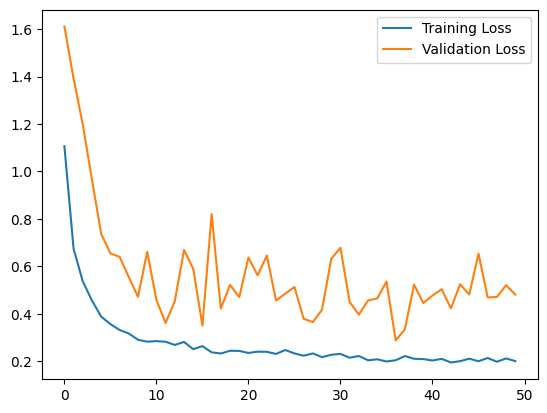

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Training Loss","Validation Loss"])
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

12/12 [==============================] - 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

     downdog       0.99      0.99      0.99        79
     goddess       0.97      0.96      0.97        73
       plank       0.98      1.00      0.99        60
        tree       1.00      1.00      1.00        64
    warrior2       0.97      0.97      0.97        91

    accuracy                           0.98       367
   macro avg       0.98      0.98      0.98       367
weighted avg       0.98      0.98      0.98       367



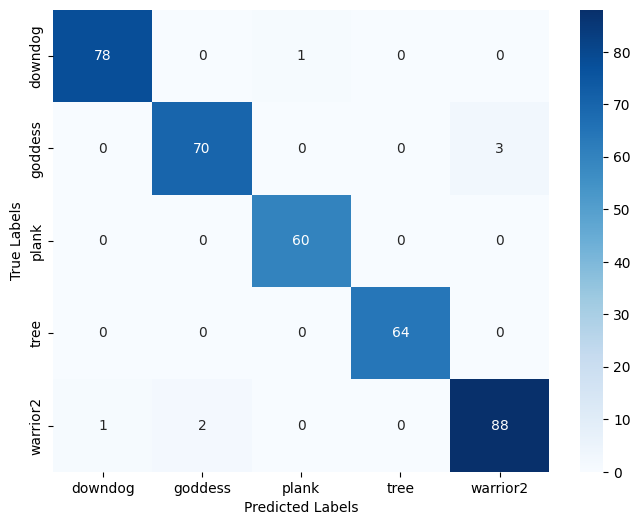

In [ ]:
predictions = model.predict(test_data)
 
predicted_labels = np.argmax(predictions, axis=1)

print("\nClassification Report:")
print(classification_report(test_labels, predicted_labels, target_names=folders))

cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=folders, yticklabels=folders)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
model.save_weights('/content/drive/MyDrive/Project/IPML/checkpoints/my_checkpoint')

In [ ]:
%%time
hits=0
miss=0
new_test_path = r"/content/drive/MyDrive/YogaData/test" ## dataset of image of group members
new_test_data = []
new_test_labels = []
for folder in folders:
    folder_path = os.path.join(new_test_path, folder)
    for img_file in os.listdir(folder_path):
      img_path = os.path.join(folder_path, img_file)

      img = cv2.imread(img_path)
      # imageWidth, imageHeight = img.shape[:2]

      imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      results = pose.process(imgRGB)
      if results.pose_landmarks:
        new_test_data.append(get_coord(results))
        new_test_labels.append(folders.index(folder))
      else:
        miss+=1

        # images.append(img)


print(hits,miss)
new_test_data = np.array(new_test_data)
new_test_labels = np.array(new_test_labels)

0 2
CPU times: user 33.7 s, sys: 1.32 s, total: 35 s
Wall time: 35.6 s


12/12 [==============================] - 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

     downdog       1.00      1.00      1.00        84
     goddess       0.97      0.93      0.95        73
       plank       1.00      1.00      1.00        60
        tree       0.98      1.00      0.99        64
    warrior2       0.96      0.98      0.97        91

    accuracy                           0.98       372
   macro avg       0.98      0.98      0.98       372
weighted avg       0.98      0.98      0.98       372



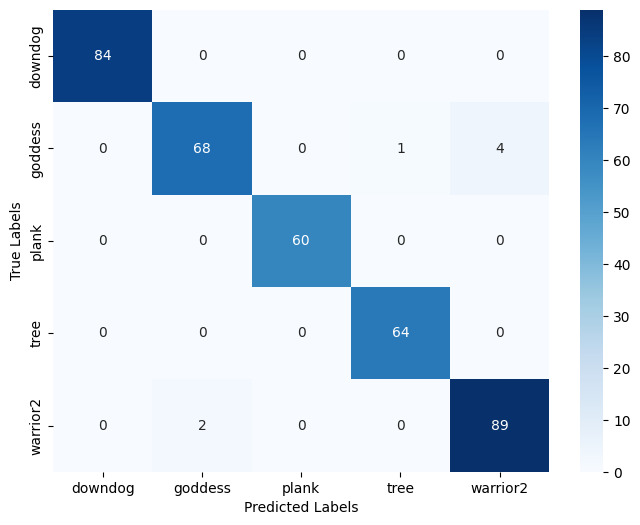

In [ ]:
predictions = model.predict(new_test_data)
 
predicted_labels = np.argmax(predictions, axis=1)

print("\nClassification Report:")
print(classification_report(new_test_labels, predicted_labels, target_names=folders))

cm = confusion_matrix(new_test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=folders, yticklabels=folders)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()